In [30]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

## Importing data (just original for now)

In [31]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [32]:
data = pd.read_csv("../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")

In [33]:
# Dropping nan classifications
data = data[data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(data))

Amount of rows: 4370


In [34]:
X = data.drop(columns=['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])
y = data[['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

## Filter by thin redshift slice (optional)

In [35]:
z = 0.6
#z = 3
delta_z = 0.5

redshift_filt = (X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))
X_sliced = X[redshift_filt]

In [36]:
# Transforming y
# Transforming y
le = preprocessing.LabelEncoder()

y = le.fit_transform(y[redshift_filt]['Classification'])

# Splitting into train and testing set

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_sliced, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

## Filling nan's

In [41]:
imp = IterativeImputer(max_iter=100, min_value=0)
X_train = imp.fit_transform(X_train)

X_test = imp.transform(X_test)
X_val = imp.transform(X_val)

## Scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Running UMAP

In [43]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1)
X_train = reducer.fit_transform(X_train, y_train)

X_test = reducer.transform(X_test)
X_val = reducer.transform(X_val)

# Training supervised model

In [47]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)

In [48]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8421    0.2162    0.3441        74
           1     0.0000    0.0000    0.0000        21
           2     0.2143    0.1154    0.1500        26
           3     0.6993    0.9727    0.8137       220

    accuracy                         0.6833       341
   macro avg     0.4389    0.3261    0.3269       341
weighted avg     0.6503    0.6833    0.6111       341



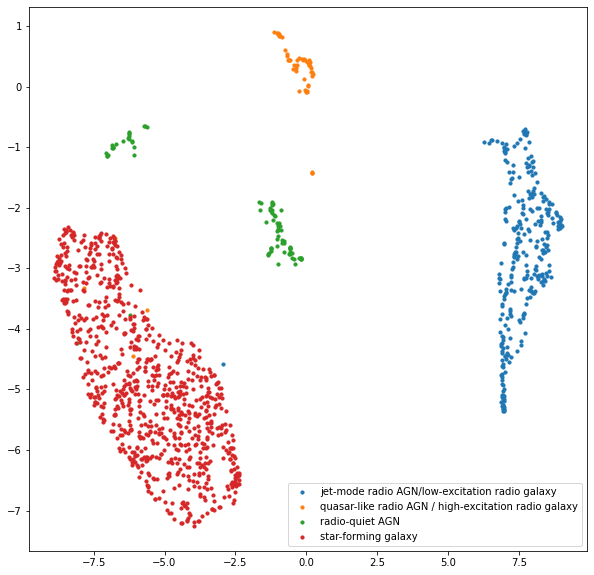

In [56]:
plt.figure(figsize=(10,10))

for i, cl in enumerate(le.classes_):
    #filt = y.loc[sample.index]['Classification']==i
    filt = y_train == i
    plt.scatter(X_train[:,0][filt], X_train[:,1][filt], s=10,label=cl)
plt.legend()
plt.show()

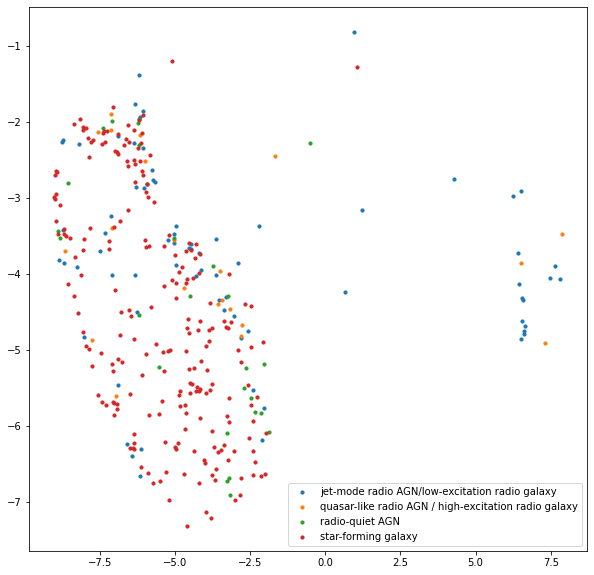

In [58]:
plt.figure(figsize=(10,10))

for i, cl in enumerate(le.classes_):
    #filt = y.loc[sample.index]['Classification']==i
    filt = y_test == i
    plt.scatter(X_test[:,0][filt], X_test[:,1][filt], s=10,label=cl)
plt.legend()
plt.show()